<a href="https://colab.research.google.com/github/laffertybrian/The-Update-Series/blob/main/Food_Sales_Prediction_Update_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Food Sales Prediction Project Update #1
This update will add a Class to quickly assess best models, and was inspired by this post: https://towardsdatascience.com/benchmarking-machine-learning-models-with-cross-validation-and-matplotlib-in-python-4957a41149e

###Loading libraries and dataframe

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [2]:
# Load dataset
filename = '/content/drive/MyDrive/01 Python for Data Science/sales_predictions.csv'
df = pd.read_csv(filename)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


###Exploring missing data

In [3]:
# ensure that data has missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
# looking at missing data by columns
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
# double checking for duplicates
df.duplicated().sum()

0

In [6]:
# viewing the data differently than I did the first time to see if I come to the same conclusion.
df.groupby('Outlet_Identifier', dropna=False)['Outlet_Size'].count()

Outlet_Identifier
OUT010      0
OUT013    932
OUT017      0
OUT018    928
OUT019    528
OUT027    935
OUT035    930
OUT045      0
OUT046    930
OUT049    930
Name: Outlet_Size, dtype: int64

In [7]:
df.groupby('Outlet_Establishment_Year', dropna=False)['Outlet_Size'].count()

Outlet_Establishment_Year
1985    1463
1987     932
1997     930
1998       0
1999     930
2002       0
2004     930
2007       0
2009     928
Name: Outlet_Size, dtype: int64

In [8]:
df.groupby(['Outlet_Identifier', 'Outlet_Establishment_Year'], dropna=False)['Outlet_Size'].count()

Outlet_Identifier  Outlet_Establishment_Year
OUT010             1998                           0
OUT013             1987                         932
OUT017             2007                           0
OUT018             2009                         928
OUT019             1985                         528
OUT027             1985                         935
OUT035             2004                         930
OUT045             2002                           0
OUT046             1997                         930
OUT049             1999                         930
Name: Outlet_Size, dtype: int64

In [9]:
df.groupby(['Outlet_Identifier', 'Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size'], dropna=False)['Outlet_Size'].count()

Outlet_Identifier  Outlet_Type        Outlet_Location_Type  Outlet_Size
OUT010             Grocery Store      Tier 3                NaN              0
OUT013             Supermarket Type1  Tier 3                High           932
OUT017             Supermarket Type1  Tier 2                NaN              0
OUT018             Supermarket Type2  Tier 3                Medium         928
OUT019             Grocery Store      Tier 1                Small          528
OUT027             Supermarket Type3  Tier 3                Medium         935
OUT035             Supermarket Type1  Tier 2                Small          930
OUT045             Supermarket Type1  Tier 2                NaN              0
OUT046             Supermarket Type1  Tier 1                Small          930
OUT049             Supermarket Type1  Tier 1                Medium         930
Name: Outlet_Size, dtype: int64

In [10]:
df.groupby(['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size'], dropna=False)['Outlet_Size'].count()

Outlet_Type        Outlet_Location_Type  Outlet_Size
Grocery Store      Tier 1                Small          528
                   Tier 3                NaN              0
Supermarket Type1  Tier 1                Medium         930
                                         Small          930
                   Tier 2                Small          930
                                         NaN              0
                   Tier 3                High           932
Supermarket Type2  Tier 3                Medium         928
Supermarket Type3  Tier 3                Medium         935
Name: Outlet_Size, dtype: int64

>In the end I am going to choose to replace the missing data the same way I did before. 

1.   Grocery Stores only have Outlet_Size of Small.
2.   Supermarket Type1, Tier 2 stores have an Outlet_Size of Small.

> I will imputer the missing data in the Outlet_Size column with the value of Small.

>The missing Weight values will be imputed with the mean value.

I will impute the data with SimpleImputer below.



###Spliting the data into X and y. Preforming train/test split.

In [11]:
# creating X and y split
# Target for this data is the 'Item_Outlet_Sales' column
y = df['Item_Outlet_Sales']

# Separating these feature columns to make predictions about the target
X = df.drop(columns = ['Item_Identifier', 'Item_Outlet_Sales'])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

###Preparing the Data

####Addressing Inconsistent Data

In [12]:
# The Fat_Content column has inconsistent data labels
# We will correct this with a dictionary
fat_content_labels = {'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg': 'Regular'}

# correcting X_train
X_train['Item_Fat_Content'].replace(fat_content_labels, inplace=True)

# correcting X_test
X_test['Item_Fat_Content'].replace(fat_content_labels, inplace=True)

####Instantiate column selectors

In [13]:
# creatintg column selectors
# for int and float types
number_selector = make_column_selector(dtype_include='number')
# for object types I will select which columns will be ordinal or nominal
nominal_columns = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Type']
ordinal_columns = ['Outlet_Size', 'Outlet_Location_Type']

####Imputing data

In [14]:
# Instantiate SimpleImputer for the numeric data in column 'Weight'
mean_imputer = SimpleImputer(strategy='mean')

In [15]:
# impute missing category data by instantiating anohter SimpleImputer
constant_value_imputer = SimpleImputer(strategy='constant', fill_value='Small')

####Creating lists for ordinal encoding

In [16]:
# creating ordered lists for both Outlet_Size and Outlet_Location_Type
# Outlet_Size from Small, Medium, High
outlet_size_labels = ['Small', 'Medium', 'High']

# outlet_location_type from tier1, tier2, tier3
location_type_labels = ['Tier 1', 'Tier 2', 'Tier 3']

# creating another list to order the labels into the encoder
ordered_labels = [outlet_size_labels, location_type_labels]

####Instantiate transformers

In [17]:
# Creating a scaler for numeric data columns
scaler = StandardScaler()

# Creating one hot encoder for categorical columns
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# creating an ordinal encoder with ordered labels 
ordinal_encoder = OrdinalEncoder(categories=ordered_labels)

####Creating pipelines

In [18]:
# Pipeline for numeric data
numeric_pipe = make_pipeline(mean_imputer, scaler)

# Pipeline for categorical data
categorical_pipe = make_pipeline(one_hot_encoder)

# Pipeline for ordinal data
ordinal_pipe = make_pipeline(constant_value_imputer, ordinal_encoder, scaler)

####Instantiate Column Transformers

In [19]:
# Tuples for use in transformer
number_tuple = (numeric_pipe, number_selector)
category_tuple = (categorical_pipe, nominal_columns)
ordinal_tuple = (ordinal_pipe, ordinal_columns)

# Column Transformer
preprocessor = make_column_transformer(number_tuple, category_tuple, ordinal_tuple, remainder='passthrough')

####Fit preprocessor

In [20]:
# Fitting preprocessor on training data
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f79bc028bb0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Type']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Small',
                                                                strategy='constant')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size', 'Outlet_Location_Type'])])

####Process training and test data

In [21]:
# Transforming training and test data with preprocessor
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

####View processed data

In [22]:
# printing na values and data types
print(f'There are {np.isnan(X_train_processed).sum().sum()} missing values in training data!')
print(f'There are {np.isnan(X_test_processed).sum().sum()} missing values in testing data!')
print('\n'+ "-"*42 + '\n')
print(f'All data types in X_train_processed are {X_train_processed.dtype}.')
print(f'All data types in X_test_processed are {X_test_processed.dtype}.')
print('\n'+ "-"*42 + '\n')
print(f'The shape of the NumPy array is {X_train_processed.shape}.')
print('\n'+ "-"*42 + '\n')
X_train_processed

There are 0 missing values in training data!
There are 0 missing values in testing data!

------------------------------------------

All data types in X_train_processed are float64.
All data types in X_test_processed are float64.

------------------------------------------

The shape of the NumPy array is (6392, 38).

------------------------------------------



array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         0.66886204,  1.08494779],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         0.66886204,  1.08494779],
       [-0.13151196,  1.81331864,  0.24454056, ...,  0.        ,
         0.66886204, -1.38477667],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  0.        ,
        -0.79983124, -0.14991444],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  0.        ,
        -0.79983124, -0.14991444],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  0.        ,
        -0.79983124, -1.38477667]])

###Update 1:
- Creating a class to quickly evaluate models.
- Model and metric selection are variable

In [23]:
# Loading libraries
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [24]:
class StartingPoint:
  def __init__(self, models, scoring):
    self.models = models

  def test_models(self, X, y, cv = 5):
    self.results = {}
    for name, model in self.models.items():
      scores = model_selection.cross_validate(model, X, y, scoring = scoring, cv = cv)
      for test, result in scores.items():
        scores[test] = result.mean()
      self.results[name] = scores

    return pd.DataFrame.from_dict(self.results, orient='index')

  def max_min(self, df):
    return pd.concat([df.idxmax().rename('model_max'), df.max().rename('score_max'), 
                           df.idxmin().rename('model_min'), df.min().rename('score_min')], axis = 1)


  def plot_results(self, df):
    for key, value in df.to_dict().items():    
        plt.figure(figsize = (15, 8))
        x = np.arange(len(value))
        plt.bar(x, list(value.values()), align = 'center', color = 'b')
        plt.xticks(x,list(value.keys()))
        plt.ylabel('Cross-Validation Score')
        plt.xlabel('Models')
        plt.title(f'{key} scores')
        for index, value in enumerate(value.values()):
          plt.text(index, (value * 1.05), str(round(value,2)))
        plt.show()

In [25]:
models = {'linear_regession': LinearRegression(),
          'decision_tree': DecisionTreeRegressor(),
          'random_forest': RandomForestRegressor(),
          'ridge': Ridge(),
          'lasso': Lasso(),
          'knn': KNeighborsRegressor(),
          'xgb': XGBRegressor()}

scoring = ['neg_mean_absolute_error', 'r2', 'max_error']

In [ ]:
seven_model_test = StartingPoint(models, scoring)
test_results = seven_model_test.test_models(X_train_processed, y_train)

In [27]:
test_results

,fit_time,score_time,test_neg_mean_absolute_error,test_r2,test_max_error
linear_regession,0.086531,0.022050,-851.988225,0.556602,-6177.372170
decision_tree,0.193477,0.008222,-1076.029502,0.195798,-6954.281000
random_forest,6.600232,0.096705,-798.560099,0.560436,-5980.680328
ridge,0.006124,0.001758,-851.907117,0.556637,-6180.273480
lasso,0.066650,0.001757,-850.719371,0.557355,-6186.686361
knn,0.002776,0.214882,-873.631891,0.496237,-6599.249808
xgb,0.910545,0.007767,-767.111882,0.597930,-5861.446226


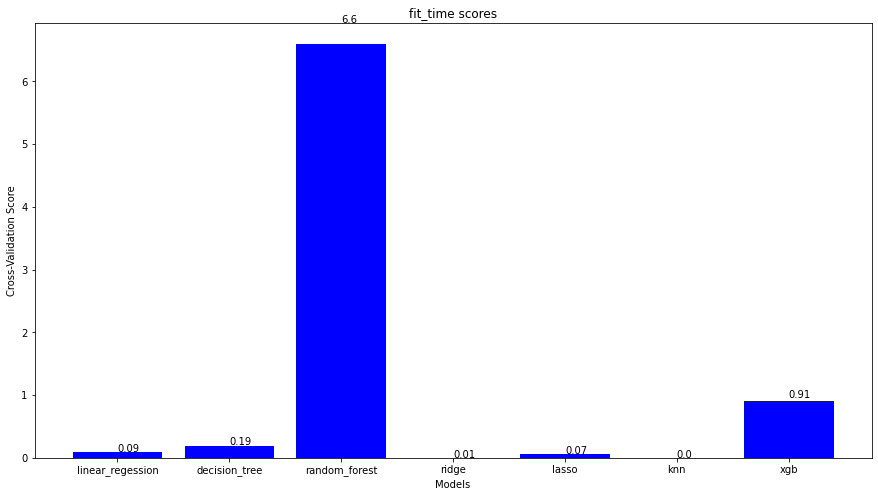

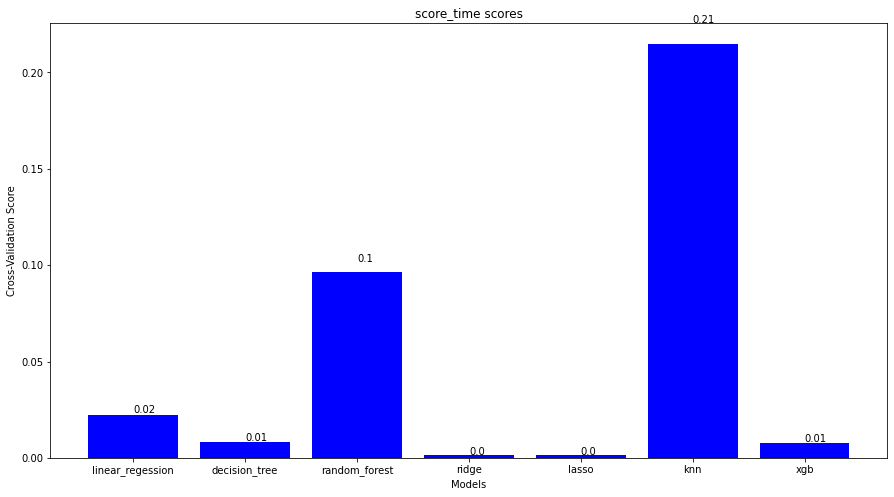

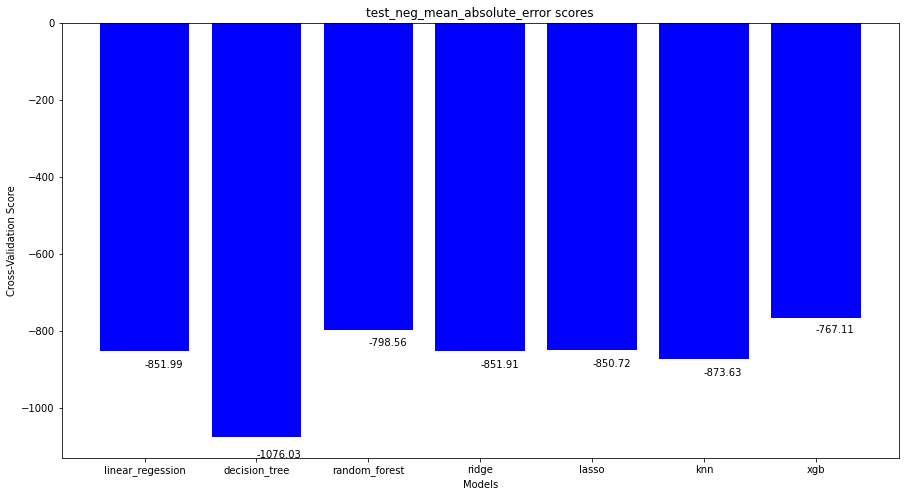

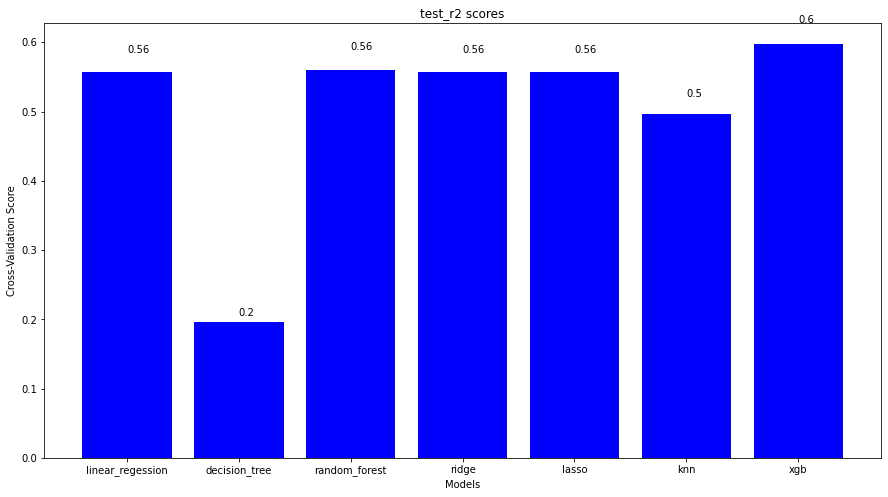

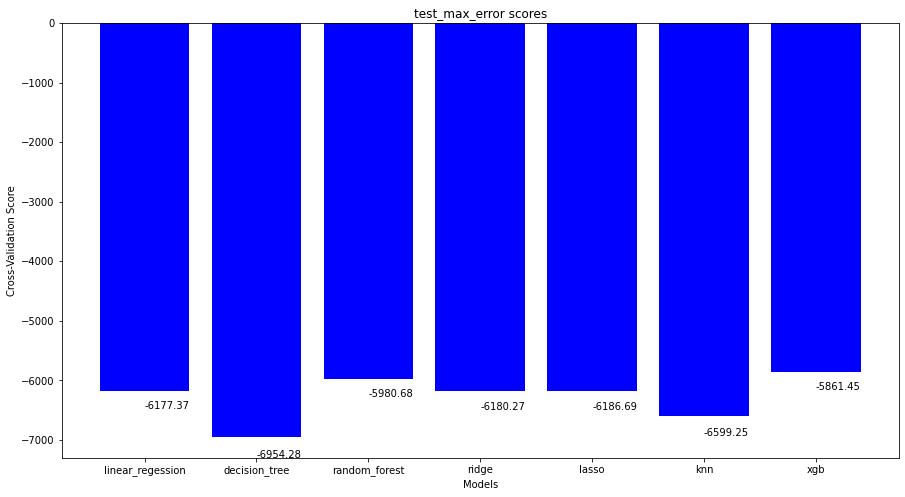

In [28]:
seven_model_test.plot_results(test_results)

In [29]:
seven_model_test.max_min(test_results)

,model_max,score_max,model_min,score_min
fit_time,random_forest,6.600232,knn,0.002776
score_time,knn,0.214882,lasso,0.001757
test_neg_mean_absolute_error,xgb,-767.111882,decision_tree,-1076.029502
test_r2,xgb,0.597930,decision_tree,0.195798
test_max_error,xgb,-5861.446226,decision_tree,-6954.281000


If I had used this class on my first project I would have choosen a differnt model to tune. I would have seen improved results.

###Model Assessment

####Linear Regression Model

In [30]:
# Instantiate the Linear Regression Model
linear_regression_model = LinearRegression()

# Fit the linear regression model on the training data
linear_regression_model.fit(X_train_processed, y_train)

# Using the model to predict targets on the test set
linear_regression_predictions = linear_regression_model.predict(X_test_processed)

In [31]:
# Evaluating the performace of the linear regression model
# R^2
linear_regression_r2 = r2_score(y_test, linear_regression_predictions)
print(f'The Linear Regression Model R^2 score is {linear_regression_r2}')

# RMSE
linear_regression_rmse = np.sqrt(mean_squared_error(y_test, linear_regression_predictions))
print(f'The Linear Regression Model RMSE score is {linear_regression_rmse}')

The Linear Regression Model R^2 score is 0.565400284442562
The Linear Regression Model RMSE score is 1095.011755421011


####Regression Tree Model

In [32]:
# Instantiate the decision tree model
decision_tree = DecisionTreeRegressor(random_state=42)

# Fitting the model to the training data
decision_tree.fit(X_train_processed, y_train)

# predicting target values with the decision tree model
decision_tree_predictions = decision_tree.predict(X_test_processed)

In [33]:
# Evaluating the performace of the decision tree model
print('Decision Tree Model before hyperparameter tuning')

# R^2
decision_tree_r2 = r2_score(y_test, decision_tree_predictions)
print(f'The Decision Tree Model R^2 score is {decision_tree_r2}')

# RMSE
decision_tree_rmse = np.sqrt(mean_squared_error(y_test, decision_tree_predictions))
print(f'The Decision Tree Model RMSE score is {decision_tree_rmse}')

Decision Tree Model before hyperparameter tuning
The Decision Tree Model R^2 score is 0.1782602077635025
The Decision Tree Model RMSE score is 1505.709607881764


In [34]:
# finding the depth of the decision tree
decision_tree.get_depth()

40

In [35]:
# creating the range of depth for the model
depth_range = list(range(2, 41))
# list to hold the values from each test run
decision_tree_r2_list = []
# using a for loop to cycle through the range of depth in the tree
for depth in depth_range:
  decision_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
  decision_tree.fit(X_train_processed, y_train)
  score = decision_tree.score(X_test_processed, y_test)
  decision_tree_r2_list.append(score)

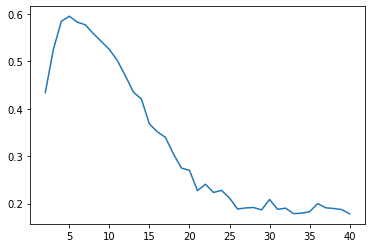

In [36]:
# plotting the R^2 value as the model is tuned
plt.plot(depth_range, decision_tree_r2_list);

In [37]:
decision_tree_r2_dict = dict(zip(depth_range, decision_tree_r2_list))
# selecting the best r^2 in the dictionary
# variables for best r^2 and depth
best_r2 = 0
best_depth = 0
# checking the dictionary for the best R^2 result
for depth, r2 in decision_tree_r2_dict.items():
  current_r2 = r2
  if current_r2 > best_r2:
    best_r2 = r2
    best_depth = depth

print(f'The best depth of the decision tree is {best_depth} since it yeilds the best R^2 of {best_r2}')

The best depth of the decision tree is 5 since it yeilds the best R^2 of 0.5947099753159972


In [38]:
# Re-running the model with the best hyperparapters
# Instantiate the decision tree model with max depth at 15
decision_tree = DecisionTreeRegressor(max_depth=5 ,random_state=42)

# Fitting the model to the training data
decision_tree.fit(X_train_processed, y_train)

# predicting target values with the decision tree model
decision_tree_predictions = decision_tree.predict(X_test_processed)

####Model Recommendation and Performance

>I would not recommend either model to predict Item_Outlet_Sales. Here are some additional metrics to understand the best performing decision tree model. I will summarize the findings at the end of this section.

In [39]:
# Calculating the MAE, MSE, and additional metrics.
# Calculating the Mean Absolute Error
mae = mean_absolute_error(y_test, decision_tree_predictions)
print(f'The Mean Absolute Error of the Decision Tree is {mae}.')

# Calculating the Mean Squared Error
mse = mean_squared_error(y_test, decision_tree_predictions)
print(f'The Mean Squared Error of the Decision Tree is {mse}.')

# Printing the Root Mean Squared Error calculated previously
rmse = np.sqrt(mse)
print(f'The Root Mean Squared Error of the Decision Tree is {rmse}.') 

# Printing the R^2 calculated previously
r2 = r2_score(y_test, decision_tree_predictions)
print(f'The R^2 of the Decision Tree is {r2}.')

The Mean Absolute Error of the Decision Tree is 738.3173097797822.
The Mean Squared Error of the Decision Tree is 1118185.973077762.
The Root Mean Squared Error of the Decision Tree is 1057.4431299496734.
The R^2 of the Decision Tree is 0.5947099753159972.


In [40]:
# Creating a dataframe to better understand the performance of the decision tree model
dec_tree_predictions = pd.Series(decision_tree_predictions)
findings_df = pd.concat([y_test.reset_index(), dec_tree_predictions.reset_index()], axis=1)
findings_df.set_axis(['drop', 'Item_Outlet_Sales', 'double drop', 'Predictions'], axis=1, inplace=True)
# removing the indexes that were created when the data series were merged.
findings_df.drop(columns = ['drop', 'double drop'], inplace=True)

# creating a function to categorize the performance of the model
def difference_sorter(x):
  if x < 50:
    return 'less than 50'
  elif x < 100:
    return 'between 50 and 99'
  elif x < 200:
    return 'between 100 and 199'
  elif x < 350:
    return 'between 200 and 349'
  elif x < 500:
    return 'between 350 and 499'
  elif x < 1000:
    return 'between 500 and 999'
  else:
    return 'greater than 1000'

# Creating a column in the dataframe that shows the absolute difference between test and prediction values
findings_df['Absolute_Difference'] = findings_df.apply(lambda row: abs(row.Item_Outlet_Sales - row.Predictions), axis=1)

findings_df['Difference'] = findings_df.apply(lambda row: row.Item_Outlet_Sales - row.Predictions, axis=1)

# creating a column using the above function to categorize the differences calculated
findings_df['Sorted_Difference'] = findings_df['Absolute_Difference'].apply(difference_sorter)
findings_df.head()

,Item_Outlet_Sales,Predictions,Absolute_Difference,Difference,Sorted_Difference
0,1743.0644,1141.520153,601.544247,601.544247,between 500 and 999
1,356.8688,730.151568,373.282768,-373.282768,between 350 and 499
2,377.5086,730.151568,352.642968,-352.642968,between 350 and 499
3,5778.4782,5240.872776,537.605424,537.605424,between 500 and 999
4,2356.9320,3008.585683,651.653683,-651.653683,between 500 and 999


In [41]:
# Exploring the sorted difference column for number of occurances
findings_df['Sorted_Difference'].value_counts()

greater than 1000      555
between 500 and 999    498
between 200 and 349    270
between 100 and 199    267
between 350 and 499    235
between 50 and 99      166
less than 50           140
Name: Sorted_Difference, dtype: int64

In [42]:
# Exploring the difference column with describe
findings_df['Difference'].describe()

count    2131.000000
mean      -28.140648
std      1057.316734
min     -3882.772310
25%      -550.452083
50%       -59.785566
75%       429.660477
max      5609.102672
Name: Difference, dtype: float64

In [43]:
# exploring the absolute difference column with describe
findings_df['Absolute_Difference'].describe()

count    2131.000000
mean      738.317310
std       757.193880
min         0.295911
25%       179.421351
50%       493.702449
75%      1032.282254
max      5609.102672
Name: Absolute_Difference, dtype: float64

Text(0.5, 1.0, 'Number of Predictions by Difference')

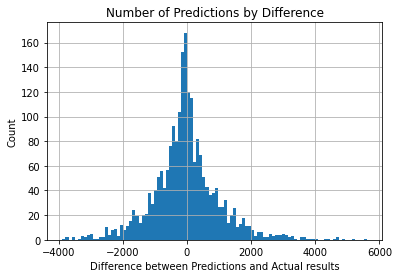

In [44]:
# Creating a histogram to better understand the Decision Tree Model Performance
findings_df['Difference'].hist(bins=100);
# Creating x label and y label
plt.xlabel('Difference between Predictions and Actual results')
plt.ylabel('Count')

# Creating title for the histogram
plt.title('Number of Predictions by Difference')

>I do not recommend using the Decision Tree Model for predicting the Item_Outlet_Sales for these reasons:



*   The MSE is 738.31. This shows that the models average error is 738.31 dollars per item prediction. The average value of Item_Outlet_Sales is 2181.29 dollars, so the error represents approximately 33% of the total sales.

*   The model can predict the Item_Outlet_Sales target within 100 dollars 14.36% of the time.
*   The model had 555 predictions that were over 1000 dollars off of the actual value. That represents approximately 26% of the predictions.


*   49% of the values had predictions over 500 dollars from the actual value.

>The model did have some positive characteristics. 



*   When comparing all of the predictions the mean was -28. Suggesting that the model over predicts and under predicts values at aproximately the same rate. In my mind it is better to under promise and over deliver. In this case the model under predicts meaning that it could generate more item sales that it would forcast, when viewed on a macro level.




As I continue my journey in Data Science I may be able to conintue to tune or improve this model.



>